In [43]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

RAW_DATA_DIR = "../data/raw/"
CLEAN_DATA_DIR = "../data/clean/"

# Basic Cleaning
- column name formatting
- generating primary key psu_hh_idcode
- removing columns with high NA rates with threshold
- removing columns with multi-colinearity
- mapping binary responses to 0 and 1

In [83]:
def import_education(path=os.path.join(RAW_DATA_DIR, "train_Education.csv")): 
    Education = pd.read_csv(path)
    Education['psu_hh_idcode'] = Education['psu'].astype(str) + '_' + Education['hh'].astype(str) + '_' + Education['idcode'].astype(str)
    Education.drop(columns=['psu', 'hh', 'idcode'], inplace=True)
    Education = Education[['psu_hh_idcode'] + [col for col in Education.columns if col != 'psu_hh_idcode']]
    Education.columns = [col.capitalize() if col.lower().startswith('q') else col for col in Education.columns]
    print("Initial Education training set:")
    display(Education.head(3))
    return Education

def import_house(path=os.path.join(RAW_DATA_DIR, "train_HouseholdInfo.csv")):
    HouseholdInfo = pd.read_csv(path)
    HouseholdInfo['psu_hh_idcode'] = HouseholdInfo['psu'].astype(str) + '_' + HouseholdInfo['hh'].astype(str) + '_' + HouseholdInfo['idcode'].astype(str)
    HouseholdInfo = HouseholdInfo[['psu_hh_idcode'] + [col for col in HouseholdInfo.columns if col != 'psu_hh_idcode']]
    HouseholdInfo.drop(columns=['psu', 'idcode', 'hh'], inplace=True)
    print("Initial HouseholdInfo training set:")
    display(HouseholdInfo.head(3))
    return HouseholdInfo

def remove_cols_high_na(df, threshold=0.3):
    # NA rate
    na_counts = df.isna().sum()
    nrow = len(df)
    na_rate = na_counts / nrow
    na_rate = na_rate.sort_values(ascending=False)
    cols_to_drop = na_rate[na_rate > threshold] # default threshold = 30%
    print(f"=> Removed {len(cols_to_drop)} Columns from Education due to NA rates above threshold={threshold*100}%\n")
    # display(list(cols_to_drop.index))

    df = df.drop(columns=cols_to_drop.index)
    print("Education after dropping columns with high NA rate:")
    display(df.head(3))
    return df

def correlational_matrix_heatmap(data, fig_size=(6,6), cols_to_exclude=[]):
    data_variates = data.drop(columns=cols_to_exclude)
    cor_matrix = data_variates.corr()
    
    # Plot heatmap
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)

    # Move x-axis labels to the top
    ax.xaxis.tick_top()  # Moves x-axis labels to the top
    ax.xaxis.set_label_position('top')  # Sets the label position to the top

    plt.show()

def categorical_encoder(data, col, range_of_values, fill_na=np.nan):
    col_index = data.columns.get_loc(col)

    # One-hot encode the specified categorical column
    encoder = OneHotEncoder(categories=[range_of_values], sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(data[[col]])  # Fix: Ensure data[[col]] is used as input

    # Convert to DataFrame with correct column names
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)

    # Rename columns to remove '.0' suffix if present
    encoded_df.columns = [name.replace('.0', '') for name in encoded_df.columns]

    # Fill in missing values as 0
    encoded_df[data[col].isna()] = 0

    # Drop the original column and combine with the encoded columns
    return_df = data.drop(columns=[col])
    for i, encoded_col in enumerate(encoded_df.columns):
        return_df.insert(col_index + i, encoded_col, encoded_df[encoded_col])
    return return_df

# Cleaning HouseholdInfo Train Set

In [86]:
house_train = import_house(path=os.path.join(RAW_DATA_DIR, "train_HouseholdInfo.csv"))

def clean_house(house_train):
    house_train = remove_cols_high_na(house_train, threshold=0.1)

    # Basic cleaning
    house_train.drop(columns=['q04'], inplace=True) # dropping q04 because date of birth is unnecessary when we have age
    house_train['q05'] = house_train['q05y'] # age is just in years, not years,months
    house_train.drop(columns=['q05y', 'q05m'], inplace=True)

    print("Correlation Matrix to check Multi-colinearity")
    # correlational_matrix_heatmap(house_train, fig_size=(6,6), cols_to_exclude=['psu_hh_idcode', 'hhid'])

    # AFTER CORRELATION ANALYSIS
    house_train.drop(columns=['q10'], inplace=True) # q10 has 0 variance, its not very useful as an explanatory variable. get rid of it

    # Map binary responses to 1 (yes) or 0 (no)
    house_train['q11'] = house_train['q11'].map({1: 'Yes', 2: 'No'}).map({'Yes': 1, 'No': 0})

    house_train['q17'] = house_train['q17'].map({1: 'Yes', 2: 'No'}).map({'Yes': 1, 'No': 0})

    # q11 and q17 seems to be highly correlated so we decided to combine the two
    house_train['q23'] = house_train['q11'] + house_train['q17']
    house_train.drop(columns=['q11', 'q17'], inplace=True)
    
    # Sort columns order
    house_train = house_train[['psu_hh_idcode', 'hhid'] + [col for col in sorted(house_train.columns) if col not in ['psu_hh_idcode', 'hhid']]]

    # one-hot-encoding
    house_train = categorical_encoder(house_train, 'q03', range_of_values=list(range(1,15)), fill_na=0)

    print("HouseholdInfo after dropping columns with high correlations")
    display(house_train.head(3))
    return house_train

house_train = clean_house(house_train)
# correlational_matrix_heatmap(house_train, fig_size=(6,6), cols_to_exclude=['psu_hh_idcode', 'hhid'])

# Output to CSV
house_train.to_csv(os.path.join(CLEAN_DATA_DIR, "train_HouseholdInfo_clean_oh_encoded.csv"), index=False)

Initial HouseholdInfo training set:


,psu_hh_idcode,hhid,q02,q03,q04,q05y,q05m,q06,q07,q08,...,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22
0,1_2_1,102,1,1,19600711,52,1,1.0,1.0,2.0,...,3.0,2.0,80.0,NaN,2,NaN,3.0,2.0,80.0,NaN
1,1_2_2,102,2,2,19650225,47,6,1.0,1.0,1.0,...,3.0,2.0,67.0,NaN,2,NaN,3.0,2.0,74.0,NaN
2,1_3_1,103,1,1,19540203,58,7,1.0,1.0,2.0,...,2.0,2.0,85.0,NaN,2,NaN,2.0,2.0,67.0,NaN


=> Removed 13 Columns from Education due to NA rates above threshold=10.0%

Education after dropping columns with high NA rate:


,psu_hh_idcode,hhid,q02,q03,q04,q05y,q05m,q09,q10,q11,q17
0,1_2_1,102,1,1,19600711,52,1,0,1,2,2
1,1_2_2,102,2,2,19650225,47,6,0,1,2,2
2,1_3_1,103,1,1,19540203,58,7,0,1,2,2


Correlation Matrix to check Multi-colinearity
HouseholdInfo after dropping columns with high correlations


,psu_hh_idcode,hhid,q02,q03_1,q03_2,q03_3,q03_4,q03_5,q03_6,q03_7,q03_8,q03_9,q03_10,q03_11,q03_12,q03_13,q03_14,q05,q09,q23
0,1_2_1,102,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52,0,0
1,1_2_2,102,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,0,0
2,1_3_1,103,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58,0,0


# Cleaning Education Train Set

In [87]:
edu_train = import_education(path=os.path.join(RAW_DATA_DIR, "train_Education.csv"))
def clean_edu(edu_train):
    edu_train = remove_cols_high_na(edu_train, threshold=0.3)
    print("Correlation Matrix to check Multi-colinearity")
    #correlational_matrix_heatmap(edu_train, fig_size=(8,8), cols_to_exclude='psu_hh_idcode')

    cols_to_drop_multicolinear = ['Q02', 'Q04', 'Q05', 'Q14', 'Q17', 'Q18']
    edu_train.drop(columns=cols_to_drop_multicolinear, inplace=True)
    print("=> Columns to remove due to high correlation with another variate", cols_to_drop_multicolinear)

    print("Education after dropping columns with high correlations")
    display(edu_train.head(3))

    edu_train = edu_train[['psu_hh_idcode'] + [col for col in sorted(edu_train.columns) if col not in ['psu_hh_idcode']]]

    # mapping values
    edu_train['Q01'] = edu_train['Q01'].map({1: "yes, easily", 2: "yes, with difficulty", 3: "no"}).map({"yes, easily": 2, "yes, with difficulty": 1, "no": 0})
    edu_train['Q03'] = edu_train['Q03'].map({1: "yes", 2: "no"}).map({"yes": 1, "no": 0})
    edu_train['Q08'] = edu_train['Q08'].map({1: "yes", 2: "no"}).map({"yes": 1, "no": 1})

    # missing values
    edu_train['Q06'] = edu_train['Q06'].fillna(0)
    edu_train['Q07'] = edu_train['Q07'].fillna(0)
    edu_train['Q08'] = edu_train['Q08'].fillna(-1)
    
    # One-hot-encoding: Q1
    edu_train = categorical_encoder(edu_train, 'Q01', range_of_values=[0,1,2], fill_na=0)

    # One-hot encoding: Q11
    edu_train = categorical_encoder(edu_train, 'Q11', range_of_values=list(range(1,14)), fill_na=0)

    return edu_train
    

edu_train = clean_edu(edu_train)
#correlational_matrix_heatmap(edu_train, fig_size=(6,6), cols_to_exclude='psu_hh_idcode')

    # Output to CSV
edu_train.to_csv(os.path.join(CLEAN_DATA_DIR, "train_Education_clean_oh_encoded.csv"), index=False)
edu_train.head()

Initial Education training set:


,psu_hh_idcode,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q09,...,Q57,Q58,Q59,Q60,Q61,Q62,Q63,Q64,Q65,Q66
0,2_8_3,1,1,1,2.0,3.0,3.0,2.0,1.0,1.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,2.0
1,3_8_4,1,1,1,2.0,2.0,2.0,0.0,1.0,1.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,2.0
2,6_5_3,1,1,1,2.0,3.0,3.0,0.0,1.0,1.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,4.0


=> Removed 53 Columns from Education due to NA rates above threshold=30.0%

Education after dropping columns with high NA rate:


,psu_hh_idcode,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q11,Q14,Q17,Q18,Q19
0,2_8_3,1,1,1,2.0,3.0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN
1,3_8_4,1,1,1,2.0,2.0,2.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN
2,6_5_3,1,1,1,2.0,3.0,3.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN


Correlation Matrix to check Multi-colinearity
=> Columns to remove due to high correlation with another variate ['Q02', 'Q04', 'Q05', 'Q14', 'Q17', 'Q18']
Education after dropping columns with high correlations


,psu_hh_idcode,Q01,Q03,Q06,Q07,Q08,Q11,Q19
0,2_8_3,1,1,3.0,2.0,1.0,NaN,NaN
1,3_8_4,1,1,2.0,0.0,1.0,NaN,NaN
2,6_5_3,1,1,3.0,0.0,1.0,NaN,NaN


,psu_hh_idcode,Q01_0,Q01_1,Q01_2,Q03,Q06,Q07,Q08,Q11_1,Q11_2,...,Q11_5,Q11_6,Q11_7,Q11_8,Q11_9,Q11_10,Q11_11,Q11_12,Q11_13,Q19
0,2_8_3,0.0,0.0,1.0,1,3.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,3_8_4,0.0,0.0,1.0,1,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,6_5_3,0.0,0.0,1.0,1,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,7_7_3,0.0,0.0,1.0,1,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,16_2_4,0.0,0.0,1.0,1,2.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


# SubjectivePoverty

In [52]:
SubjectivePoverty = pd.read_csv(os.path.join(RAW_DATA_DIR, "train_SubjectivePoverty.csv"))
subjective_poverty_columns = [f'subjective_poverty_{i}' for i in range(1, 11)]
SubjectivePoverty['subjectivePoverty_rating'] = SubjectivePoverty[subjective_poverty_columns].idxmax(axis=1).str.extract('(\d+)').astype(int)
Ratings = SubjectivePoverty[['psu_hh_idcode', 'subjectivePoverty_rating']]

# Three of the subjects in SubjectivePoverty train set do not show up in either Education or Household train sets. We get rid of these from subjectivePoverty
# Get the IDs from household and education DataFrames
household_ids = set(house_train['psu_hh_idcode'])
education_ids = set(edu_train['psu_hh_idcode'])
valid_ids = household_ids.union(education_ids)
# Filter ratings_df to keep only rows with IDs present in valid_ids
Ratings = Ratings[Ratings['psu_hh_idcode'].isin(valid_ids)]

display(Ratings.head(3))

Ratings.to_csv(os.path.join(CLEAN_DATA_DIR, "train_SubjectivePoverty_clean.csv"), index=False)

,psu_hh_idcode,subjectivePoverty_rating
0,30_8_1,4
1,194_1_2,1
2,224_6_1,3


In [84]:
def generate_merged_set(house_df, edu_df, subjective_poverty_df=None, impute_ratings=False, save_to=None):
    train_or_test = "TRAIN" if subjective_poverty_df is not None else "TEST"
    filled_or_unfilled = "UNFILLED" if impute_ratings is False else "FILLED"

    if save_to is None:
        save_to = f"../data/model_training/{train_or_test}_{filled_or_unfilled}_encoded.csv"

    X = house_train.merge(edu_train, on='psu_hh_idcode', how='inner')
    print(f"X.shape: {X.shape}")

    # fill in Q19 based on q05
    X['Q19'] = X['Q19'].fillna(X['q05'].apply(lambda x: 1 if x is not None and x <= 19 else 0))

    if subjective_poverty_df is None:
        merged_test_input = X
        merged_test_input = merged_test_input[['psu_hh_idcode']+ [col for col in merged_test_input.columns if col not in ['psu_hh_idcode', 'hhid']]]
        print("TEST_INPUT.csv:", merged_test_input.shape, f"=> {merged_test_input.shape[1]-1} features")
        merged_test_input.to_csv(save_to, index=False)
        return merged_test_input
    
    train_labelled = X.merge(Ratings, on='psu_hh_idcode', how='inner')
    train_labelled.shape

    labelled_ids = set(Ratings['psu_hh_idcode'])
    print("Count of labelled ID's:", len(labelled_ids))

    cols = ['psu_hh_idcode', 'subjectivePoverty_rating'] + [col for col in train_labelled.columns if col not in ['psu_hh_idcode', 'subjectivePoverty_rating']]
    train_labelled = train_labelled[cols]
    train_labelled = train_labelled.drop(columns=['hhid'])

    if impute_ratings == False: 
        print("train data [labelled only]:", train_labelled.shape)
        train_labelled.to_csv(save_to, index=False)
        return train_labelled
        


    # Filling in missing subjectiveRating labels with the assumption "same household => same rating" 
    train_all = X.merge(Ratings[['psu_hh_idcode', 'subjectivePoverty_rating']], on='psu_hh_idcode', how='outer')
    cols = ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating'] + [col for col in train_all.columns if col not in ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating']]
    merged_train_outer = train_all[cols] # data frame containing all rows

    ratings_by_household = train_all[train_all['subjectivePoverty_rating'].notna()][['hhid', 'subjectivePoverty_rating']]
    ratings_by_household = ratings_by_household.groupby('hhid').mean().reset_index().rename(columns={'subjectivePoverty_rating': 'avg_rating_hh'})
    ratings_by_household.head()

    train_unlabelled = train_all[train_all['subjectivePoverty_rating'].isna()]
    n_unlabelled = len(train_unlabelled)
    print(f"Count of unlablled ID's in Train Set: {n_unlabelled}")

    train_imputed = train_unlabelled.merge(ratings_by_household, on='hhid', how='left')
    train_imputed = train_imputed.drop(columns=['subjectivePoverty_rating']).rename(columns={'avg_rating_hh': 'subjectivePoverty_rating'})

    n_imputed = len(train_imputed[train_imputed['subjectivePoverty_rating'].notna()])
    print(f"Count of succesfully imputed ID's in Train Set: {n_imputed}")
    print(f"=> {round(n_imputed/n_unlabelled * 100,1)}% of unlabelled data imputed")
    train_imputed_labelled = pd.concat([train_labelled.assign(imputed=0), train_imputed.assign(imputed=1)], axis=0, ignore_index=True)

    # reorder cols
    cols = ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating', 'imputed'] + [col for col in merged_train_outer.columns if col not in ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating', 'imputed']]
    train_imputed_labelled = train_imputed_labelled[cols]


    # # drop rows with missing ratings now (15% of all rows)
    train_imputed_labelled = train_imputed_labelled[train_imputed_labelled['subjectivePoverty_rating'].notna()]

    n_labelled = len(train_imputed_labelled[train_imputed_labelled['imputed'] == 0])
    n = len(train_imputed_labelled)
    print(f"=> originally labelled data: {round(n_labelled/len(train_imputed_labelled)*100, 1)}% of training data ({n_labelled} out of {n})")
    print(f"=> data from mean imputation: {round(n_imputed/len(train_imputed_labelled)*100, 1)}% of training data ({n_imputed} out of {n})")

    train_imputed_labelled = train_imputed_labelled.drop(columns=['hhid', 'imputed'])

    print("train data [labelled and imputed]:", train_imputed_labelled.shape)

    train_imputed_labelled.to_csv(save_to, index=False)
    return train_imputed_labelled
    
    

# Create a Merged Train Set (Unfilled)

In [78]:
train_labelled = generate_merged_set(house_train, edu_train, Ratings, impute_ratings=False, save_to="../data/model_training/TRAIN_MERGED_UNFILLED_encoded.csv")

X.shape: (22406, 41)
Count of labelled ID's: 5334
train data [labelled only]: (5334, 41)


In [82]:
train_imputed_labelled = generate_merged_set(house_train, edu_train, Ratings, impute_ratings=True, save_to="../data/model_training/TRAIN_MERGED_FILLED_encoded.csv")
train_imputed_labelled.head()

X.shape: (22406, 41)
Count of labelled ID's: 5334
Count of unlablled ID's in Train Set: 17072
Count of succesfully imputed ID's in Train Set: 13620
=> 79.8% of unlabelled data imputed
=> originally labelled data: 28.1% of training data (5334 out of 18954)
=> data from mean imputation: 71.9% of training data (13620 out of 18954)
train data [labelled and imputed]: (18954, 41)


,psu_hh_idcode,subjectivePoverty_rating,q02,q03_1,q03_2,q03_3,q03_4,q03_5,q03_6,q03_7,...,Q11_5,Q11_6,Q11_7,Q11_8,Q11_9,Q11_10,Q11_11,Q11_12,Q11_13,Q19
0,1_2_1,2.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,1_3_1,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1_5_1,6.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1_11_1,6.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,1_12_1,4.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


# Build Test Input File

Initial HouseholdInfo training set:


,psu_hh_idcode,hhid,q02,q03,q04,q05y,q05m,q06,q07,q08,...,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22
0,1_7_1,107,1,1,19400717,72,1,1,1.0,2.0,...,2.0,2.0,90.0,NaN,2,NaN,2.0,2.0,90.0,NaN
1,1_8_1,108,1,1,19480715,64,1,2,2.0,NaN,...,3.0,2.0,61.0,NaN,2,NaN,3.0,2.0,85.0,NaN
2,1_10_1,110,1,1,19430612,69,2,1,1.0,2.0,...,2.0,2.0,75.0,NaN,2,NaN,3.0,2.0,66.0,NaN


=> Removed 8 Columns from Education due to NA rates above threshold=10.0%

Education after dropping columns with high NA rate:


,psu_hh_idcode,hhid,q02,q03,q04,q05y,q05m,q06,q09,q10,q11,q13,q14,q17,q19,q20
0,1_7_1,107,1,1,19400717,72,1,1,0,1,2,2.0,2.0,2,2.0,2.0
1,1_8_1,108,1,1,19480715,64,1,2,0,1,2,3.0,2.0,2,3.0,2.0
2,1_10_1,110,1,1,19430612,69,2,1,0,1,2,2.0,2.0,2,3.0,2.0


Correlation Matrix to check Multi-colinearity


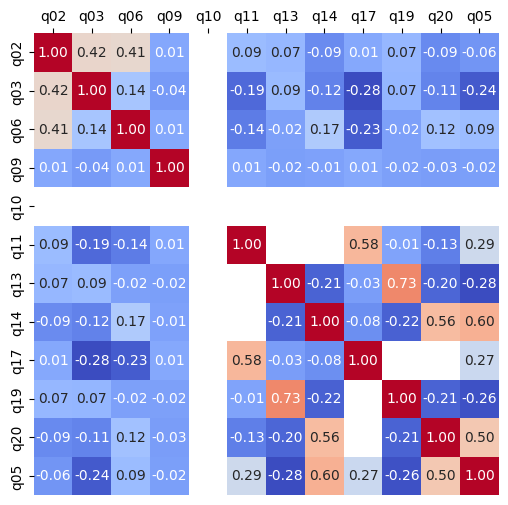

HouseholdInfo after dropping columns with high correlations


,psu_hh_idcode,hhid,q02,q03_1,q03_2,q03_3,q03_4,q03_5,q03_6,q03_7,...,q03_13,q03_14,q05,q06,q09,q13,q14,q19,q20,q23
0,1_7_1,107,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,72,1,0,2.0,2.0,2.0,2.0,0
1,1_8_1,108,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,64,2,0,3.0,2.0,3.0,2.0,0
2,1_10_1,110,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,69,1,0,2.0,2.0,3.0,2.0,0


Initial Education training set:


,psu_hh_idcode,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q09,...,Q57,Q58,Q59,Q60,Q61,Q62,Q63,Q64,Q65,Q66
0,648_6_4,1,1,1,6.0,1.0,3.0,3.0,1.0,1.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,2.0
1,756_3_3,1,1,1,6.0,1.0,3.0,0.0,1.0,1.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,4.0
2,164_8_3,1,1,1,6.0,3.0,3.0,3.0,1.0,1.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,6.0


=> Removed 53 Columns from Education due to NA rates above threshold=30.0%

Education after dropping columns with high NA rate:


,psu_hh_idcode,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q11,Q14,Q17,Q18,Q19
0,648_6_4,1,1,1,6.0,1.0,3.0,3.0,1.0,NaN,1.0,NaN,NaN,NaN
1,756_3_3,1,1,1,6.0,1.0,3.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN
2,164_8_3,1,1,1,6.0,3.0,3.0,3.0,1.0,NaN,1.0,NaN,NaN,NaN


Correlation Matrix to check Multi-colinearity


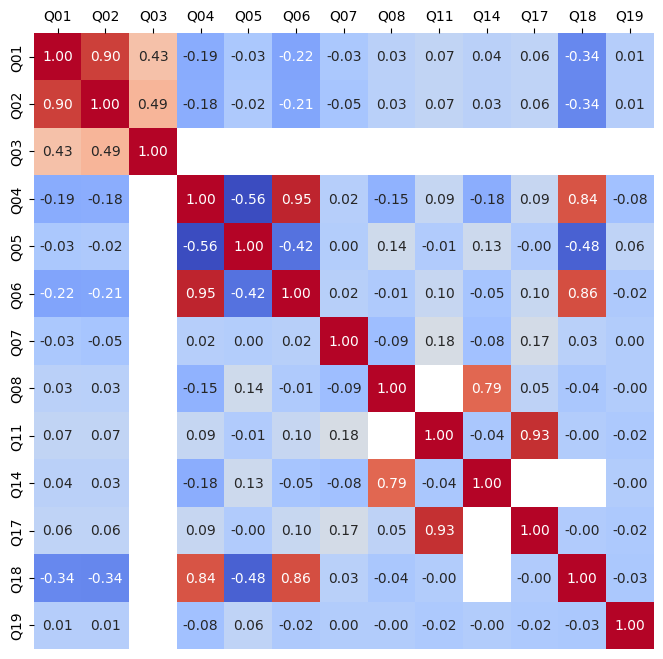

=> Columns to remove due to high correlation with another variate ['Q02', 'Q04', 'Q05', 'Q14', 'Q17', 'Q18']
Education after dropping columns with high correlations


,psu_hh_idcode,Q01,Q03,Q06,Q07,Q08,Q11,Q19
0,648_6_4,1,1,3.0,3.0,1.0,NaN,NaN
1,756_3_3,1,1,3.0,0.0,1.0,NaN,NaN
2,164_8_3,1,1,3.0,3.0,1.0,NaN,NaN


X.shape: (22406, 41)
TEST_INPUT.csv: (22406, 41) => 40 features


,psu_hh_idcode,hhid,q02,q03_1,q03_2,q03_3,q03_4,q03_5,q03_6,q03_7,...,Q11_5,Q11_6,Q11_7,Q11_8,Q11_9,Q11_10,Q11_11,Q11_12,Q11_13,Q19
0,1_2_1,102,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,1_2_2,102,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1_3_1,103,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,1_3_2,103,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,1_3_3,103,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [85]:
house_test = import_house("../data/raw/test_HouseholdInfo.csv")
house_test = clean_house(house_test)

edu_test = import_education("../data/raw/test_Education.csv")
edu_test = clean_edu(edu_test)

merged_test_input = generate_merged_set(house_test, edu_test, save_to="../data/clean/TEST_INPUT_encoded.csv")
merged_test_input.head()

In [50]:
cols_to_keep = ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating', 'q02', 'q03', 'q05', 'q09', 'q23', 'Q01', 'Q03', 'Q06', 'Q07', 'Q08', 'Q11', 'Q19']

house_test = pd.read_csv(os.path.join(RAW_DATA_DIR, "test_HouseholdInfo.csv"))
house_test['psu_hh_idcode'] = house_test['psu'].astype(str) + '_' + house_test['hh'].astype(str) + '_' + house_test['idcode'].astype(str)
house_test.drop(columns=['psu', 'hh', 'idcode', 'hhid'], inplace=True)
house_test['q05'] = house_test['q05y']
house_test['q23'] = house_test['q11'] + house_test['q17']
house_test = house_test.drop(columns=[col for col in house_test.columns if col not in cols_to_keep])
house_test = house_test[['psu_hh_idcode', 'q02', 'q03', 'q05', 'q09', 'q23']]
print("test_HouseholdInfo.csv:", house_test.shape, f"=> {house_test.shape[1]-1} features")
display(house_test.head(3))

edu_test = pd.read_csv(os.path.join(RAW_DATA_DIR, "test_Education.csv"))
edu_test['psu_hh_idcode'] = edu_test['psu'].astype(str) + '_' + edu_test['hh'].astype(str) + '_' + edu_test['idcode'].astype(str)
edu_test.columns = [col.capitalize() if col.lower().startswith('q') else col for col in edu_test.columns]
edu_test = edu_test.drop(columns=['psu', 'hh', 'idcode'])
edu_test.drop(columns=[col for col in edu_test.columns if col not in cols_to_keep], inplace=True)
edu_test = edu_test[['psu_hh_idcode', 'Q01', 'Q03', 'Q06', 'Q07', 'Q08', 'Q11', 'Q19']]
print()
print("test_Education.csv:", edu_test.shape, f"=> {edu_test.shape[1]-1} features")
display(edu_test.head(3))

merged_test_input = house_test.merge(edu_test, on='psu_hh_idcode', how='inner')
print()
print("Columns with missing data:\n")
for col in ['Q06', 'Q07', 'Q08', 'Q11', 'Q19']:
    print(f"{col}:", sorted(list(merged_test_input[col].unique())))

# OKAY how do we fill in missing vals in each col
# Q06
# Q07
# Q08
# Q11
# Q19
# => fill with -1 for now
merged_test_input['Q06'] = merged_test_input['Q06'].fillna(-1)
merged_test_input['Q07'] = merged_test_input['Q07'].fillna(-1)
merged_test_input['Q08'] = merged_test_input['Q08'].fillna(-1)
merged_test_input['Q11'] = merged_test_input['Q11'].fillna(-1)
merged_test_input['Q19'] = merged_test_input['Q19'].fillna(-1)

print("TEST_INPUT.csv:", merged_test_input.shape, f"=> {merged_test_input.shape[1]-1} features")
display(merged_test_input.head())
display(merged_test_input.isna().mean())
# Output to CSV
merged_test_input.to_csv(os.path.join(CLEAN_DATA_DIR, "TEST_INPUT.csv"), index=False)

test_HouseholdInfo.csv: (1334, 6) => 5 features


,psu_hh_idcode,q02,q03,q05,q09,q23
0,1_7_1,1,1,72,0,4
1,1_8_1,1,1,64,0,4
2,1_10_1,1,1,69,0,4



test_Education.csv: (1334, 8) => 7 features


,psu_hh_idcode,Q01,Q03,Q06,Q07,Q08,Q11,Q19
0,648_6_4,1,1,3.0,3.0,1.0,NaN,NaN
1,756_3_3,1,1,3.0,0.0,1.0,NaN,NaN
2,164_8_3,1,1,3.0,3.0,1.0,NaN,NaN



Columns with missing data:

Q06: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, nan, 10.0, 11.0]
Q07: [0.0, 1.0, 2.0, 4.0, nan, 3.0]
Q08: [2.0, nan, 1.0]
Q11: [1.0, 2.0, 3.0, 4.0, 8.0, 13.0, nan, 10.0, 12.0, 14.0]
Q19: [2.0, nan, 1.0]
TEST_INPUT.csv: (1334, 13) => 12 features


,psu_hh_idcode,q02,q03,q05,q09,q23,Q01,Q03,Q06,Q07,Q08,Q11,Q19
0,1_7_1,1,1,72,0,4,1,1,1.0,1.0,2.0,13.0,2.0
1,1_8_1,1,1,64,0,4,1,1,2.0,1.0,2.0,13.0,2.0
2,1_10_1,1,1,69,0,4,1,1,9.0,0.0,2.0,13.0,2.0
3,2_3_1,1,1,53,0,4,1,1,3.0,0.0,2.0,2.0,2.0
4,3_1_1,1,1,48,0,4,1,1,2.0,0.0,2.0,2.0,2.0
